In [2]:
import cfgrib
import xarray as xr
import os
import pygrib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import datetime, time
from sklearn.preprocessing import KBinsDiscretizer

<frozen importlib._bootstrap>:219: UserWarning: Warning: ecCodes 2.19.1 or higher is recommended. You are running 2.17.0.


In [345]:
!export ECCODES_DEFINITION_PATH=/Users/macbook/opt/anaconda3/share/eccodes/definitions

In [75]:
ds = cfgrib.open_file('/Users/macbook/Documents/SML/Project/ncar/pgbh06.gdas.20100111-20100115.grb2',
                     filter_by_keys={'typeOfLevel': 'unknown'})

In [ ]:
#check out the data:
ds.dimensions.keys()

In [13]:
ds = cfgrib.open_dataset('/Users/macbook/Documents/SML/Project/ncar/pgbh06.gdas.20100126-20100131.grb2', 
                         backend_kwargs={'filter_by_keys':{'typeOfLevel':'unknown'}})

In [15]:
ds.variables

Frozen({'time': <xarray.IndexVariable 'time' (time: 24)>
array(['2010-01-26T00:00:00.000000000', '2010-01-26T06:00:00.000000000',
       '2010-01-26T12:00:00.000000000', '2010-01-26T18:00:00.000000000',
       '2010-01-27T00:00:00.000000000', '2010-01-27T06:00:00.000000000',
       '2010-01-27T12:00:00.000000000', '2010-01-27T18:00:00.000000000',
       '2010-01-28T00:00:00.000000000', '2010-01-28T06:00:00.000000000',
       '2010-01-28T12:00:00.000000000', '2010-01-28T18:00:00.000000000',
       '2010-01-29T00:00:00.000000000', '2010-01-29T06:00:00.000000000',
       '2010-01-29T12:00:00.000000000', '2010-01-29T18:00:00.000000000',
       '2010-01-30T00:00:00.000000000', '2010-01-30T06:00:00.000000000',
       '2010-01-30T12:00:00.000000000', '2010-01-30T18:00:00.000000000',
       '2010-01-31T00:00:00.000000000', '2010-01-31T06:00:00.000000000',
       '2010-01-31T12:00:00.000000000', '2010-01-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      init

In [ ]:
timeLevel = ds.variables['time'].data
timeLevel

In [12]:
ds.vars

NameError: name 'ds' is not defined

In [17]:
dsn = ds.stack(z=("time", "latitude", "longitude"))
dsni = dsn.indexes["z"]
dsni = dsni.to_frame(index=False)
dsni["paramId_0"] = dsn.paramId_0.values.tolist()

MultiIndex([('2010-01-26 00:00:00', 50.0, 232.0),
            ('2010-01-26 00:00:00', 50.0, 232.5),
            ('2010-01-26 00:00:00', 50.0, 233.0),
            ('2010-01-26 00:00:00', 50.0, 233.5),
            ('2010-01-26 00:00:00', 50.0, 234.0),
            ('2010-01-26 00:00:00', 50.0, 234.5),
            ('2010-01-26 00:00:00', 50.0, 235.0),
            ('2010-01-26 00:00:00', 50.0, 235.5),
            ('2010-01-26 00:00:00', 50.0, 236.0),
            ('2010-01-26 00:00:00', 50.0, 236.5),
            ...
            ('2010-01-31 18:00:00', 30.0, 282.5),
            ('2010-01-31 18:00:00', 30.0, 283.0),
            ('2010-01-31 18:00:00', 30.0, 283.5),
            ('2010-01-31 18:00:00', 30.0, 284.0),
            ('2010-01-31 18:00:00', 30.0, 284.5),
            ('2010-01-31 18:00:00', 30.0, 285.0),
            ('2010-01-31 18:00:00', 30.0, 285.5),
            ('2010-01-31 18:00:00', 30.0, 286.0),
            ('2010-01-31 18:00:00', 30.0, 286.5),
            ('2010-01-31 18:00:00'

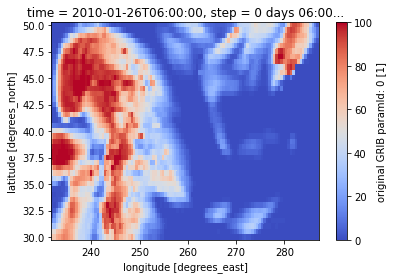

In [343]:
ds.paramId_0[1].plot(cmap=plt.cm.coolwarm)

# Real Work

##### Importing files and merging them

In [22]:
lfiles = sorted(os.listdir('/Users/macbook/Documents/SML/Project/ncar4/'))[1:] 
## I made sure that there are no files other the ones starting with "pgbh06", and 
## make sure that you also remove the first file which is there just to keep the last data point, and
## it does not have time dimension, so removing it otherwise it would create issue in the below loop over the files

In [33]:
merged_data = pd.DataFrame()

for file in lfiles:
    print(file)
    data = cfgrib.open_dataset(f'/Users/macbook/Documents/SML/Project/ncar4/{file}', 
                         backend_kwargs={'filter_by_keys':{'typeOfLevel':'unknown'}})
    data_keys = list(data.keys())
    data = data.stack(z=("time", "latitude", "longitude"))
    temp_frame = data.indexes["z"].to_frame(index=False)
    for key in data_keys:
        temp_frame[f"{key}"] = getattr(data, key).values.tolist()
    temp_frame.dropna(inplace=True)
    merged_data = merged_data.append(temp_frame)  

pgbh06.gdas.20100101-20100105.grb2
pgbh06.gdas.20100106-20100110.grb2
pgbh06.gdas.20100111-20100115.grb2
pgbh06.gdas.20100116-20100120.grb2
pgbh06.gdas.20100121-20100125.grb2
pgbh06.gdas.20100126-20100131.grb2
pgbl06.gdas.20100101-20100105.grb2
pgbl06.gdas.20100106-20100110.grb2
pgbl06.gdas.20100111-20100115.grb2
pgbl06.gdas.20100116-20100120.grb2
pgbl06.gdas.20100121-20100125.grb2
pgbl06.gdas.20100126-20100131.grb2


###### Preprocessing merged dataset to later join it with our fires dataset
1. Creating new column for Day of Year
2. Moving to per day representation of data from 6 hr format
3. Binning the latitude and longitude

In [34]:
merged_data['DOY'] = merged_data['time'].dt.dayofyear
merged_data['Year'] = merged_data['time'].dt.year
merged_data = merged_data.groupby(['DOY','latitude','longitude','Year'], as_index=False).mean()

In [36]:
min(merged_data['longitude'])

225.0

In [37]:
merged_data['longitude'] = merged_data['longitude'] - 360

In [38]:
merged_data['latitude'] = pd.cut(merged_data['latitude'], bins=np.arange(17, 71, 0.5).tolist())
merged_data['longitude'] = pd.cut(merged_data['longitude'], bins=np.arange(-179, -64, 0.5).tolist())

In [41]:
merged_data = merged_data.dropna()

In [42]:
merged_data

,DOY,latitude,longitude,Year,paramId_0,pres,t
0,1,"(27.5, 28.0]","(-135.5, -135.0]",2010,40.75,21082.5,217.177002
1,1,"(27.5, 28.0]","(-135.0, -134.5]",2010,39.75,21005.0,216.951500
2,1,"(27.5, 28.0]","(-134.5, -134.0]",2010,39.50,21075.0,216.985249
3,1,"(27.5, 28.0]","(-134.0, -133.5]",2010,36.75,22132.5,219.014999
4,1,"(27.5, 28.0]","(-133.5, -133.0]",2010,31.75,22257.5,219.181999
...,...,...,...,...,...,...,...
216858,31,"(55.5, 56.0]","(-67.0, -66.5]",2010,62.50,31767.5,219.953999
216859,31,"(55.5, 56.0]","(-66.5, -66.0]",2010,68.75,32245.0,220.278004
216860,31,"(55.5, 56.0]","(-66.0, -65.5]",2010,68.75,32482.5,220.579250
216861,31,"(55.5, 56.0]","(-65.5, -65.0]",2010,66.00,32927.5,221.166248


##### Importing Fires dataset (only Lat, Long, DISCOVERY_DOY, FIRE_YEAR) 
It has Long_min, Long_max, Lat_min, Lat_max

-178.8026	-65.25694444	17.93972222	70.3306

In [377]:
fires = pd.read_csv('/Users/macbook/Documents/SML/Project/Fires.csv')

In [378]:
fires['LATITUDE'] = pd.cut(fires['LATITUDE'], bins=np.arange(17, 71, 0.5).tolist())
fires['LONGITUDE'] = pd.cut(fires['LONGITUDE'], bins=np.arange(-179, -64, 0.5).tolist())
fires['fire'] = 1
fires = fires.drop_duplicates()

##### Merging weather and fires dataset

In [399]:
Xy = pd.merge(merged_data, fires, how='left', 
         left_on=['DOY','latitude','longitude','Year'], 
         right_on=['DISCOVERY_DOY','LATITUDE','LONGITUDE','FIRE_YEAR']).drop(columns = ['DISCOVERY_DOY','LATITUDE','LONGITUDE','FIRE_YEAR'])

Xy['fire'] = Xy['fire'].fillna(0)

In [403]:
Xy['fire'].value_counts()

0.0    209344
1.0      1230
Name: fire, dtype: int64

### Dataset 2 (6 hr average data)

In [3]:
files = ['pgbh06.gdas.20100101-20100105.grb2']
merged_data1 = pd.DataFrame()

for file in files:
    print(file)
    data = cfgrib.open_dataset(f'/Users/macbook/Documents/SML/Project/{file}', 
                         backend_kwargs={'filter_by_keys':{'typeOfLevel':'unknown'}})
    data_keys = list(data.keys())
    data = data.stack(z=("time", "latitude", "longitude"))
    temp_frame = data.indexes["z"].to_frame(index=False)
    for key in data_keys:
        temp_frame[f"{key}"] = getattr(data, key).values.tolist()
    temp_frame.dropna(inplace=True)
    merged_data1 = merged_data1.append(temp_frame)  

pgbh06.gdas.20100101-20100105.grb2


In [4]:
merged_data1['DOY'] = merged_data1['time'].dt.dayofyear
merged_data1['Year'] = merged_data1['time'].dt.year
merged_data1 = merged_data1.groupby(['DOY','latitude','longitude','Year'], as_index=False).mean()
merged_data1['longitude'] = merged_data1['longitude'] - 360
merged_data1['latitude'] = pd.cut(merged_data1['latitude'], bins=np.arange(17, 71, 0.5).tolist())
merged_data1['longitude'] = pd.cut(merged_data1['longitude'], bins=np.arange(-179, -64, 0.5).tolist())
merged_data1 = merged_data1.dropna()

In [5]:
merged_data1

,DOY,latitude,longitude,Year,tcc,pres,t,cwork
126416,1,"(17.0, 17.5]","(-152.5, -152.0]",2010,3.000000,16540.000000,214.117004,0.0
126417,1,"(17.0, 17.5]","(-152.0, -151.5]",2010,4.000000,16540.000000,214.084000,0.0
126418,1,"(17.0, 17.5]","(-151.5, -151.0]",2010,4.000000,16540.000000,214.057007,0.0
126419,1,"(17.0, 17.5]","(-151.0, -150.5]",2010,3.000000,16550.000000,214.082993,0.0
126420,1,"(17.0, 17.5]","(-150.5, -150.0]",2010,1.000000,16540.000000,214.076004,0.0
...,...,...,...,...,...,...,...,...
1018416,5,"(70.0, 70.5]","(-67.0, -66.5]",2010,43.000000,31713.333333,223.234339,0.0
1018417,5,"(70.0, 70.5]","(-66.5, -66.0]",2010,35.000000,31846.666667,223.522664,0.0
1018418,5,"(70.0, 70.5]","(-66.0, -65.5]",2010,22.666667,32743.333333,224.683329,0.0
1018419,5,"(70.0, 70.5]","(-65.5, -65.0]",2010,21.000000,32710.000000,224.094498,0.0


### Dataset 3 (6 hr forecast data)

In [9]:
files1 = sorted(os.listdir('/Users/macbook/Documents/SML/Project/ncar6forecast/'))[1:]
merged_data2 = pd.DataFrame()

for file in files1:
    print(file)
    data = cfgrib.open_dataset(f'/Users/macbook/Documents/SML/Project/ncar6forecast/{file}', 
                         backend_kwargs={'filter_by_keys':{'typeOfLevel':'unknown'}})
    data_keys = list(data.keys())
    data = data.stack(z=("time", "latitude", "longitude"))
    temp_frame = data.indexes["z"].to_frame(index=False)
    for key in data_keys:
        temp_frame[f"{key}"] = getattr(data, key).values.tolist()
    temp_frame.dropna(inplace=True)
    merged_data2 = merged_data2.append(temp_frame)  

pgbh06.gdas.20080101-20080105.grb2
pgbh06.gdas.20080106-20080110.grb2
pgbl06.gdas.20080101-20080105.grb2
pgbl06.gdas.20080106-20080110.grb2


In [10]:
merged_data2['DOY'] = merged_data2['time'].dt.dayofyear
merged_data2['Year'] = merged_data2['time'].dt.year
merged_data2 = merged_data2.groupby(['DOY','latitude','longitude','Year'], as_index=False).mean()
merged_data2['longitude'] = merged_data2['longitude'] - 360
merged_data2['latitude'] = pd.cut(merged_data2['latitude'], bins=np.arange(17, 71, 0.5).tolist())
merged_data2['longitude'] = pd.cut(merged_data2['longitude'], bins=np.arange(-179, -64, 0.5).tolist())
merged_data2 = merged_data2.dropna()

In [11]:
merged_data2

,DOY,latitude,longitude,Year,cwat,r,tozne,gh,pwat,paramId_0,pres
0,1,"(29.5, 30.0]","(-82.5, -82.0]",2008,0.03,43.0,239.600006,3732.959961,31.900000,49.0,60560.0
1,1,"(29.5, 30.0]","(-82.0, -81.5]",2008,0.00,45.0,238.300003,3764.800049,33.400002,38.0,60550.0
2,1,"(29.5, 30.0]","(-81.0, -80.5]",2008,0.00,45.0,236.699997,3912.959961,34.700001,40.0,57320.0
3,1,"(29.5, 30.0]","(-80.5, -80.0]",2008,0.00,45.0,236.500000,3976.000000,35.299999,51.0,45880.0
4,1,"(29.5, 30.0]","(-80.0, -79.5]",2008,0.10,47.0,235.300003,4001.600098,35.900002,40.0,60200.0
...,...,...,...,...,...,...,...,...,...,...,...
5611,9,"(48.0, 48.5]","(-123.0, -122.5]",2008,0.18,35.0,343.799988,650.559998,10.900000,46.0,69720.0
5612,9,"(48.0, 48.5]","(-81.5, -81.0]",2008,0.89,45.0,316.399994,231.839996,15.700000,25.0,43770.0
5613,9,"(48.0, 48.5]","(-81.0, -80.5]",2008,0.87,47.0,313.100006,1845.439941,16.799999,12.0,46520.0
5614,9,"(48.5, 49.0]","(-127.5, -127.0]",2008,0.06,32.0,386.000000,683.200012,9.700000,30.0,67550.0
